# Identification of Cardio Problems / FeatureUnion Application

We have to predict cardio problems. There's given a dataset of 100 000 of real world cases. There're 3 groups of features:

- objective features:
    - age (in days)
    - height
    - weight
    - gender
- measurement results:
    - arterial pressure/high
    - arterial pressure/low
    - cholesterol (normal/above normal/very above normal)
    - glucose (normal/above normal/very above normal)
- subjective features:
    - smoking (yes/no)
    - alcohol (yes/no)
    - physical activity (yes/no)
    
Target - 'cardio'

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

import itertools
import matplotlib.pyplot as plt
%matplotlib inline

### uploading data

In [2]:
df = pd.read_csv('train_case2.csv', delimiter=';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


### train test split

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

### let's create 3 groups/lists of pipelines based on feature transformation they do

- gender, cholesterol - one-hot encoding
- age, height, weight, ap_hi, ap_lo - StandardScaler
- gluc, smoke, alco, active - leave them as they are

In [4]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]


continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []


for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

### the 3 lists of pipelines look like

In [5]:
continuos_transformers, cat_transformers, base_transformers

([('age',
   Pipeline(steps=[('selector', NumberSelector(key='age')),
                   ('standard', StandardScaler())])),
  ('height',
   Pipeline(steps=[('selector', NumberSelector(key='height')),
                   ('standard', StandardScaler())])),
  ('weight',
   Pipeline(steps=[('selector', NumberSelector(key='weight')),
                   ('standard', StandardScaler())])),
  ('ap_hi',
   Pipeline(steps=[('selector', NumberSelector(key='ap_hi')),
                   ('standard', StandardScaler())])),
  ('ap_lo',
   Pipeline(steps=[('selector', NumberSelector(key='ap_lo')),
                   ('standard', StandardScaler())]))],
 [('gender',
   Pipeline(steps=[('selector', ColumnSelector(key='gender')),
                   ('ohe', OHEEncoder(key='gender'))])),
  ('cholesterol',
   Pipeline(steps=[('selector', ColumnSelector(key='cholesterol')),
                   ('ohe', OHEEncoder(key='cholesterol'))]))],
 [('gluc', Pipeline(steps=[('selector', NumberSelector(key='gluc'))])),
  ('s

### let's unite them all into one pipeline with FeatureUnion

In [6]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)

### let's take a look on how our combined pipeline transforms the data

NB! code in this section can be deleted, it's only for demonstration purposes; feature_processing is not required in the main code

In [7]:
feature_processing = Pipeline([('feats', feats)])
feature_processing.fit_transform(X_train).shape

(52500, 14)

In [8]:
X_train.head(1)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active
4497,6369,15212,2,170,85.0,130,80,3,3,1,0,1


In [9]:
feature_processing.fit_transform(X_train)[0]

array([-1.73391771,  0.6873301 ,  0.74843904,  0.0085465 , -0.0911737 ,
        0.        ,  1.        ,  0.        ,  0.        ,  1.        ,
        3.        ,  1.        ,  0.        ,  1.        ])

as it's seen one-hot encoding added 3 more columns for 'gender' and 'cholesterol', 'age' and other continuous features were standartized, 'id' was not included

### let's upgrade our pipeline by adding a classifier

In [10]:
classifier = Pipeline([
    ('features', feats),
#     ('classifier', LogisticRegression(C=0.1, random_state = 42)),
    ('classifier', LogisticRegression(C=10, random_state = 42)),  # 'C' can be tuned to improve performance
])

# cross-validation
cv_scores = cross_val_score(classifier, X_train, y_train, cv=6, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {} +/- {} (std)'.format(cv_score, cv_score_std))

# fitting our pipeline 
classifier.fit(X_train, y_train)

# predicting probabilities
y_score = classifier.predict_proba(X_test)[:, 1]

CV score is 0.7868698300824125 +/- 0.004835306405044692 (std)


### let's find the best threshold

In [11]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b**2) * (precision * recall) / (b**2 * precision + recall)

# locate the index of the largest f-score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.386133, F-Score=0.730, Precision=0.647, Recall=0.838


### let's draw ROC curve

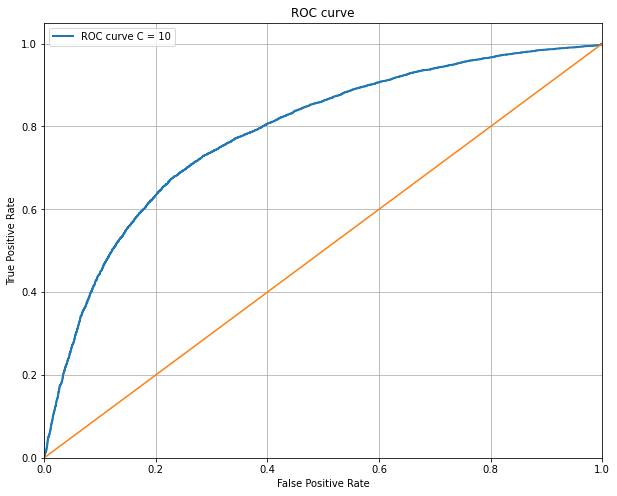

In [12]:
plt.figure(figsize=(10, 8))
# fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)  # C = 0.1
fpr_, tpr_, thresholds_ = roc_curve(y_test, y_score, pos_label=1)  # C = 10
lw = 2

# plt.plot(fpr, tpr, lw=lw, label='ROC curve2  C = 0.1')
plt.plot(fpr_, tpr_, lw=lw, label='ROC curve C = 10')

plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
# plt.savefig("ROC.png")
plt.grid()
plt.show()

### let's plot confusion matrix

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2126 6694]
 [ 367 8313]]


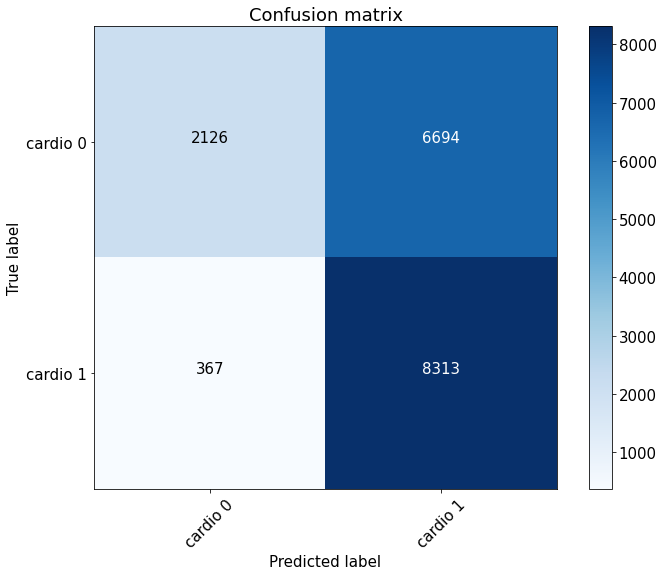

In [14]:
font = {'size' : 15}

plt.rc('font', **font)

business_threshold = 0.65  # 'business_threshold' can be tuned to impove business metrics

cnf_matrix = confusion_matrix(y_test, y_score > thresholds[ix]*business_threshold)  # !!!
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio 0', 'cardio 1'],
                      title='Confusion matrix')
# plt.savefig("conf_matrix.png")
plt.show()

### let's calculate TPR, FPR, TNR

In [15]:
TN, FP, FN, TP = confusion_matrix(y_test, y_score > thresholds[ix]*business_threshold).ravel()

In [16]:
TPR = TP/(TP+FN)
FPR = FP/(FP+TN)
TNR = TN/(FP+TN)
TPR, FPR, TNR

(0.9577188940092166, 0.7589569160997732, 0.24104308390022675)

## Business Metrics

Let's imagine that we have a business dilemma where:

- the cost of testing is 1500
- the cost of early treatment is 13000 plus the cost of testing
- the cost of late treatment is 13000

Our task is to minimize our spendings.

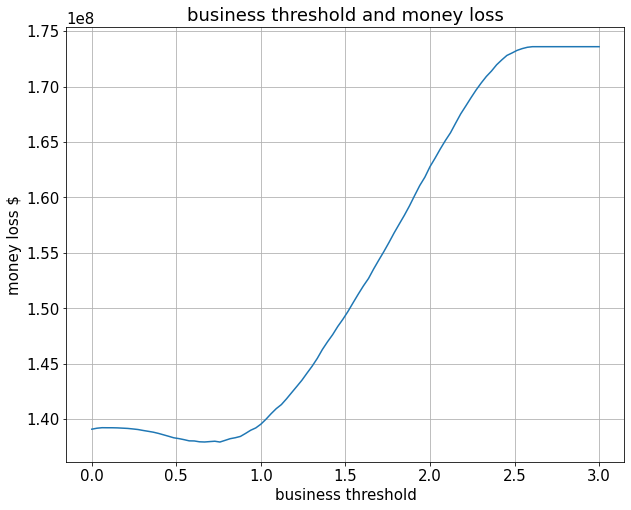

In [17]:
cost_to_test = 1500
cost_to_early_treatment = 13000 + cost_to_test
cost_to_late_treatment = 20000

money_loss =[]
business_threshold_levels = np.linspace(0, 3, 100).tolist()

for business_threshold_level in business_threshold_levels:
    TN, FP, FN, TP = confusion_matrix(y_test, y_score > thresholds[ix]*business_threshold_level).ravel()
    money_loss.append(FP*cost_to_test + TP*cost_to_early_treatment + FN*cost_to_late_treatment)

plt.figure(figsize=(10, 8))
plt.plot(business_threshold_levels, money_loss)
plt.ylabel('money loss $')
plt.xlabel('business threshold')
plt.title('business threshold and money loss')
plt.grid()
plt.show()

### here's the optimal business threshold established with ML

In [18]:
money_loss_and_bthresholds = pd.DataFrame({
    'business_threshold_levels': business_threshold_levels,
    'money_loss': money_loss  
})

money_loss_and_bthresholds.sort_values(by='money_loss', ascending=True).head(1)

,business_threshold_levels,money_loss
25,0.757576,137931500


### here's the money loss if we decide to test everyone

In [19]:
money_loss_and_bthresholds.sort_values(by='business_threshold_levels', ascending=True).head(1)

,business_threshold_levels,money_loss
0,0.0,139090000


### here's the money loss if we decide not to test at all

In [20]:
money_loss_and_bthresholds.sort_values(by='business_threshold_levels', ascending=False).head(1)

,business_threshold_levels,money_loss
99,3.0,173600000


spendings in this case are definitely the biggest

### if we subtract spendings minimized by ML from the case where we test everyone, we will have our profit

In [21]:
our_profit = money_loss_and_bthresholds.sort_values(by='business_threshold_levels', ascending=True)['money_loss'].iloc[0] -\
             money_loss_and_bthresholds.sort_values(by='money_loss', ascending=True)['money_loss'].iloc[0]
our_profit

1158500